,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


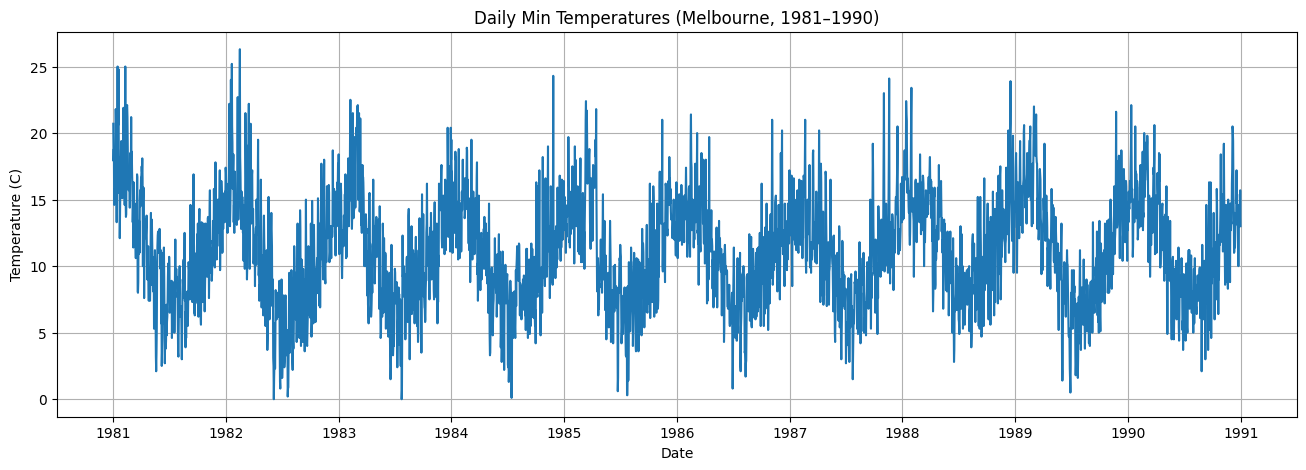

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# download dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
df = pd.read_csv(url, parse_dates=['Date'])

#the first five
display(df.head())

# visualisation
plt.figure(figsize=(16,5))
plt.plot(df['Date'], df['Temp'])
plt.title('Daily Min Temperatures (Melbourne, 1981–1990)')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.grid(True)
plt.show()


In [2]:
import numpy as np

def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Hyperparameter: window length (number of days the network learns to predict the next one)
WINDOW_SIZE = 30

# Take only temperature values (no dates)
temp_values = df['Temp'].values

# Forming training sequences
X, y = create_sequences(temp_values, WINDOW_SIZE)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (3620, 30)
y shape: (3620,)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Scaling (MinMax: 0..1)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

# LSTM wait 3D input: (samples, time_steps, features)
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], WINDOW_SIZE, 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], WINDOW_SIZE, 1)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)


X_train_scaled shape: (2896, 30, 1)
X_test_scaled shape: (724, 30, 1)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 - 4s - 47ms/step - loss: 0.0195 - mae: 0.1024 - val_loss: 0.0097 - val_mae: 0.0763
Epoch 2/20
91/91 - 2s - 24ms/step - loss: 0.0113 - mae: 0.0832 - val_loss: 0.0099 - val_mae: 0.0777
Epoch 3/20
91/91 - 1s - 16ms/step - loss: 0.0111 - mae: 0.0822 - val_loss: 0.0091 - val_mae: 0.0741
Epoch 4/20
91/91 - 2s - 26ms/step - loss: 0.0109 - mae: 0.0819 - val_loss: 0.0090 - val_mae: 0.0733
Epoch 5/20
91/91 - 2s - 19ms/step - loss: 0.0108 - mae: 0.0814 - val_loss: 0.0090 - val_mae: 0.0740
Epoch 6/20
91/91 - 1s - 15ms/step - loss: 0.0107 - mae: 0.0810 - val_loss: 0.0087 - val_mae: 0.0721
Epoch 7/20
91/91 - 1s - 15ms/step - loss: 0.0104 - mae: 0.0798 - val_loss: 0.0091 - val_mae: 0.0747
Epoch 8/20
91/91 - 2s - 19ms/step - loss: 0.0102 - mae: 0.0789 - val_loss: 0.0085 - val_mae: 0.0720
Epoch 9/20
91/91 - 3s - 29ms/step - loss: 0.0099 - mae: 0.0781 - val_loss: 0.0081 - val_mae: 0.0701
Epoch 10/20
91/91 - 2s - 26ms/step - loss: 0.0100 - mae: 0.0781 - val_loss: 0.0080 - val_mae: 0.0693
Epoch 11/2

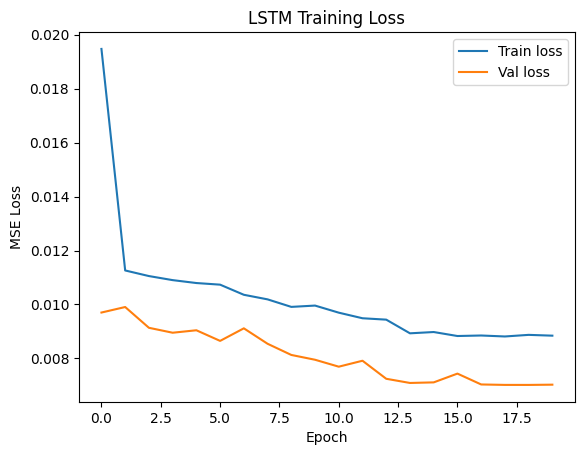

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

# create a simple LSTM-model
model = keras.Sequential([
    layers.LSTM(50, activation='tanh', input_shape=(WINDOW_SIZE, 1)),
    layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Train model
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    verbose=2
)


import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


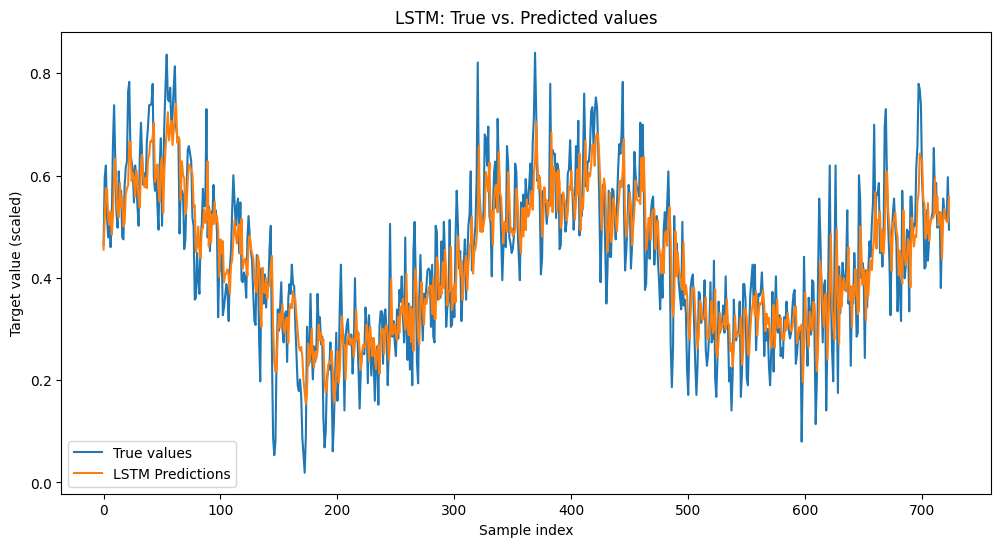

In [6]:
# 1. Predictions on the test sample
y_pred_scaled = model.predict(X_test_scaled)


y_pred = y_pred_scaled.flatten()
y_true = y_test_scaled.flatten()

# 3. Visualization: True vs Predicted Values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='True values')
plt.plot(y_pred, label='LSTM Predictions')
plt.title('LSTM: True vs. Predicted values')
plt.xlabel('Sample index')
plt.ylabel('Target value (scaled)')
plt.legend()
plt.show()


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")


Test MSE: 0.0070
Test MAE: 0.0658


In [8]:
model.save('lstm_model.h5')


In [9]:
model.save('lstm_model.keras')
